In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet 

from sklearn import tree
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Leitura de Arquivos

In [2]:
##Dados do Banco Mundial
#Gerais
path_wb = 'World_Bank' #Informando pasta onde os arquivos .csv estão 
csv_files_wb = glob.glob(path_wb + "/*.csv") #Listando todos os nomes dos arquivos .csv 
list_wb = (pd.read_csv(file, sep=',', skiprows=4) for file in csv_files_wb) #Transformando em um gerador de lista de Dataframes

df_wb = list(list_wb) #Criando a lista de Dataframe final

##Dados Externos

path_ext = 'Extern Data' 
csv_files_ext = glob.glob(path_ext + "/*.csv")
list_ext = (pd.read_csv(file, sep=',') for file in csv_files_ext)

df_ext = list(list_ext)

#Dados Externos 2 - Segundo Dataset de Liberdade Econômica do "Fraser Institute"

path_fra = 'EFW_1970_2022.csv'
df_efw_fra = pd.read_csv(path_fra, sep=';')

# Primeira vizualização e tratamento dos datasets.

In [3]:
#data_bill.country.unique()
#len(set(df_ext[3].Country).difference(set(df_hdi[0]['Country Name'])))

#set(df_ext[2].countries).difference(set(df_efw_fra.Countries))
#len(set(df_hdi[0]['Country Name']).intersection(set(df_ext[2].countries)))
#set(df_efw_fra.Countries).difference(set(df_wb[1]['Country Name']))

#len(set(df_ext[2].countries)), len(set(df_hdi[0]['Country Name']))

## Padronizando Nomes dos Países de Estudo

In [4]:
#Dataset de Bilionarios.
data_bill = df_ext[0]
data_bill.drop('Unnamed: 0', axis=1, inplace=True)
data_bill.set_index('rank')
data_bill['networth']=data_bill['networth'].str.replace('$','', regex=True)
data_bill['networth']=data_bill['networth'].str.replace(' B','', regex=True)
data_bill['networth']=data_bill['networth'].apply(pd.to_numeric)

data_bill.replace({'country': {'Eswatini (Swaziland)': 'Eswatini'}}, inplace=True)

df_ext[0] = data_bill 

####

#Dataset de Liberdade Economica.
data_efw = df_ext[2]
data_efw.replace({'countries': {'Bahamas': 'Bahamas, The',
                                'Cape Verde': 'Cabo Verde',
                                'Central Afr. Rep.': 'Central African Republic',
                                'Congo, Dem. R.': 'Congo, Dem. Rep.',
                                'Congo, Rep. Of':  'Congo, Rep.',
                                'Czech Rep.': 'Czech Republic',
                                'Dominican Rep.': 'Dominican Republic',
                                'Egypt': 'Egypt, Arab Rep.',
                                'Hong Kong': 'Hong Kong SAR, China',
                                'Iran': 'Iran, Islamic Rep.',
                                'Korea, South': 'Korea, Rep.',
                                'Laos': 'Lao PDR',
                                'Macedonia': 'North Macedonia',
                                'Pap. New Guinea': 'Papua New Guinea',
                                'Russia': 'Russian Federation',
                                'Slovak Rep': 'Slovak Republic',
                                'Swaziland': 'Eswatini',
                                'Syria': 'Syrian Arab Republic',
                                #'Taiwan',
                                'Trinidad & Tob.': 'Trinidad and Tobago',
                                'Turkey': 'Turkiye',
                                'Unit. Arab Em.': 'United Arab Emirates',
                                'Venezuela': 'Venezuela, RB'}}, inplace=True)
                                    
df_ext[2] = data_efw

####

#Dataset de Indice de Desenvolvimento Humano.
data_HDI = df_ext[3]
data_HDI['Country'] = data_HDI['Country'].astype(str)
data_HDI['Country'] = data_HDI['Country'].str.strip()
data_HDI.replace({'Country': {'Bahamas': 'Bahamas, The',
                              'Bolivia (Plurinational State of)': 'Bolivia',
                              'Congo': 'Congo, Rep.',
                              'Congo (Democratic Republic of the)': 'Congo, Dem. Rep.',
                              'Czechia': 'Czech Republic',
                              "Côte d'Ivoire": "Cote d'Ivoire",
                              'Egypt': 'Egypt, Arab Rep.',
                              'Eswatini (Kingdom of)': 'Eswatini',
                              'Gambia': 'Gambia, The',
                              'Hong Kong, China (SAR)': 'Hong Kong SAR, China',
                              'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
                              'Korea (Republic of)': 'Korea, Rep.',
                              'Kyrgyzstan': 'Kyrgyz Republic',
                              "Lao People's Democratic Republic": 'Lao PDR',
                              'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.',
                              'Moldova (Republic of)': 'Moldova',
                              'Palestine, State of': 'West Bank and Gaza',
                              'Saint Kitts and Nevis': 'St. Kitts and Nevis',
                              'Saint Lucia': 'St. Lucia',
                              'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
                              'Slovakia': 'Slovak Republic',
                              'Tanzania (United Republic of)': 'Tanzania',
                              'The former Yugoslav Republic of Macedonia': 'North Macedonia',
                              'Turkey': 'Turkiye',
                              'Venezuela (Bolivarian Republic of)': 'Venezuela, RB',
                              'Viet Nam': 'Vietnam',
                              'Yemen': 'Yemen, Rep.'}}, inplace=True)

df_ext[3] = data_HDI 
####

#Dataset de Unicornios.
data_uni = df_ext[4]
data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].str.replace('+','')
data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].astype(float)
data_uni['Country/countries'] = data_uni['Country/countries'].astype(str)
data_uni['Country/countries'] = data_uni['Country/countries'].apply(lambda x: str(x).replace(u'\xa0', u''))
data_uni.replace({'Country/countries': {'US': 'United States',
                             'US / Ireland': 'United States',
                             'UK': 'United Kingdom',
                             'UK / UAE': 'United Kingdom',
                             'Ukraine[39]/United States[40]': 'Ukraine',
                             'China / Hong Kong': 'China',
                             'Hong Kong / China': 'Hong Kong SAR, China',
                             'Portugal / US': 'Portugal',
                             'US[67]': 'United States',
                             'India / US': 'India',
                             'Australia / Hong Kong': 'Australia',
                             'China / US': 'China',
                             'UK / US': 'United Kingdom',
                             'France / US': 'France',
                             'Israel / US': 'Israel',
                             'Brazil / US': 'Brazil',
                             'US / Israel': 'United States',
                             'Argentina / US': 'Argentina',
                             'Portugal / US [308]': 'Portugal',
                             'Senegal / US': 'Senegal',
                             'Israel /  US': 'Israel',
                             'Nigeria / US': 'Nigeria',
                             'US[362]': 'United States',
                             'USA': 'United States',
                             'Spain / US': 'Spain',
                             'Germany / Russia': 'Germany',
                             'Singapore / Israel': 'Singapore',
                             'US, UK and Europe': 'United States',
                             'Singapore / Switzerland': 'Singapore',
                             'UAE': 'United Arab Emirates',
                             'Canada / USA': 'Canada',
                             'India/ US': 'India',
                             'Croatia / UK': 'Croatia',
                             'India / Singapore': 'India',
                             'Armenia / US': 'Armenia',
                             'Estonia / US': 'Estonia'}}, inplace=True)
data_uni.columns = ['Company', 'Valuation(US$ billions)', 'Valuation date', 'Industry',
       'country', 'Founder(s)']

df_ext[4] = data_uni 

####

#Dataset de EFW - Fraser Institute.

df_efw_fra = df_efw_fra[df_efw_fra['Countries'].notna()]
df_efw_fra = df_efw_fra.loc[:, 'Year' : '5  Regulation']
df_efw_fra = df_efw_fra.drop(columns=['ISO Code 2', 'ISO Code 3','data', 'data.1', 'data.2', 'data.3',
                                      'data.4', 'data.5', 'data.6', 'data.7', 'data.8', 'data.9', 'data.10'])

df_efw_fra.replace({'Countries': {#'Somalia',
                                  #'Taiwan',
                                  'Turkey': 'Turkiye'}}, inplace=True)
cols = df_efw_fra.columns[df_efw_fra.dtypes.eq('object')]

df_efw_fra['Economic Freedom Summary Index'] = df_efw_fra['Economic Freedom Summary Index'].str.replace(',','.')
df_efw_fra.iloc[:,5:] = df_efw_fra.iloc[:,5:].apply(lambda x: x.str.replace(',','.'))
df_efw_fra[cols[1:]] = df_efw_fra[cols[1:]].apply(pd.to_numeric, errors='coerce', axis=1)
df_efw_fra['Year'] = df_efw_fra['Year'].astype(int)
df_efw_fra = df_efw_fra.sort_values(by=['Countries', 'Year'])
df_efw_fra = df_efw_fra.reset_index(drop=True)
df_efw_fra = df_efw_fra.interpolate(method='linear', limit_direction='both', axis=0)

In [5]:
#df_efw_fra[df_efw_fra['Countries'] == 'Brazil'].shape

In [6]:
#df_efw_fra[df_efw_fra['Countries'] == 'Brazil'].isna().sum()

## Criação dos Dataframes de Estudo.

### World Bank 

In [7]:
DF_WB = []

countries = list(df_wb[0]['Country Name'])
size = list(range(len(df_wb)))

for x in range(len(countries)): 
    pais = countries[x]
    
    wb_years = df_wb[0].columns[4:66]
    world_bank = pd.DataFrame({'year':wb_years})
    world_bank['year'] = world_bank.year.astype(int)
    world_bank['Country'] = pais
    
    for y in size:
    
        wb = df_wb[y][df_wb[y]['Country Name'] == pais].loc[:,'1960':'2021'].transpose()
        wb = wb.reset_index()
        pin = df_wb[y]['Indicator Name'][0]
        wb.columns = ['year', pin]
        wb['year'] = wb.year.astype(int)
        world_bank = pd.merge(world_bank, wb, how = 'outer', on = 'year')
    
    DF_WB.append(world_bank)


DF_WB_std = pd.DataFrame()

for x in range(len(countries)):
    DF_WB_std = pd.concat([DF_WB_std, DF_WB[x]])
    
DF_WB_std = DF_WB_std.sort_values(by=['Country', 'year'])
DF_WB_std = DF_WB_std.reset_index(drop=True)

### Dados Externos 1

In [8]:
#Escolha dos Países para o Dataframe
countries = np.array(list(set(df_ext[2].countries).intersection(set(df_ext[3].Country))))

#Criação dos DF 
DF_one = pd.DataFrame()
DF_two = pd.DataFrame()

DF_std_ext1 = pd.DataFrame()
list_DF_std_ext2 = []

for x in range(len(countries)): 
    pais = countries[x]
    
    # Parcela A - Liberdade Economica
    a = df_ext[2][df_ext[2]['countries'] == pais].sort_values(by='year')
    a = a.reset_index()
    a = a.drop(columns=['index','ISO_code']) #, inplace=True)

    # Parcela B e C - Bilionarios
    b = df_ext[0][df_ext[0]['country'] == pais].groupby(['country']).name.count()
    c = df_ext[0][df_ext[0]['country'] == pais].groupby(['country']).networth.sum()
    
    # Parcela D - IDH
    d = df_ext[3][df_ext[3]['Country'] == pais].iloc[:,2:].transpose()
    d = d.reset_index()
    if len(set(d.columns)) > 1:
        d.columns = ['year', 'HDI']
    else:
        d.columns = ['year']
    d['year'] = d.year.astype(int)
    d
   
    # Parcela E - Melhores Paises para Startups

    e = df_ext[1][df_ext[1]['country'] == pais].iloc[:,[0,3]].transpose()
    if len(e.columns) > 0:
        e.columns = ['Startups_Score_2020']
    else:
        e
    
    # Parcela M e N - Unicórnios
    
    f = df_ext[4][df_ext[4]['country'] == pais].groupby(['country']).Company.count()
    g = df_ext[4][df_ext[4]['country'] == pais].groupby(['country'])['Valuation(US$ billions)'].sum()
   
    ####
    ####  Unindo os Dataframes
    ####
    
    DF_one = pd.merge(b, c, how = 'outer', on = 'country')
    DF_one = pd.merge(DF_one, f, how = 'outer', on = 'country')
    DF_one = pd.merge(DF_one, g, how = 'outer', on = 'country')
    DF_one = DF_one.reset_index()
    
    if e.shape[1] > 0:
        DF_one['Startups_Ranking_2020'] = e.iloc[0,0]
        DF_one['Startups_Score_2020'] = e.iloc[1,0]
    else:
        e
    
    DF_std_ext1 = pd.concat([DF_std_ext1, DF_one])
    
    ### Unindo os Dataframes em um Único.

    DF_two = pd.merge(a, d, how = 'outer', on = 'year')
    DF_two = DF_two.sort_values(by='year').reset_index(drop=True)
   
    # Preenchendo NaN dos paíes
    df_inter = DF_two.interpolate(method='linear', limit_direction='both', axis=0)
    values = {"countries": pais}
    df_inter = df_inter.fillna(value=values)
    
    list_DF_std_ext2.append(df_inter)

#### Parte 1

In [9]:
DF_std_ext2 = pd.DataFrame()
for x in range(len(countries)):
    DF_std_ext2 = pd.concat([DF_std_ext2, list_DF_std_ext2[x]])
    
DF_std_ext2 = DF_std_ext2.sort_values(by=['countries', 'year'])
DF_std_ext2 = DF_std_ext2.reset_index(drop=True)

DF_std_ext2.columns = ['Year', 'Countries', 'Economic_Freedom', 'Free_rank', 'Quartile',
                  '1.a_government_consumption', '1.b_transfers', '1.c_gov_enterprises',
                  '1.d_top_marg_tax_rate', '1.0_size_government', '2.a_judicial_independence',
                  '2.b_impartial_courts', '2.c_protection_property_rights',
                  '2.d_military_interference', '2.e_integrity_legal_system',
                  '2.f_legal_enforcement_contracts', '2.g_restrictions_sale_real_property',
                  '2.h_reliability_police', '2.i_business_costs_crime',
                  '2.j_gender_adjustment', '2.0_property_rights', '3.a_money_growth',
                  '3.b_std_inflation', '3.c_inflation', '3.d_freedom_own_foreign_currency',
                  '3.0_sound_money', '4.a_tariffs', '4.b_regulatory_trade_barriers',
                  '4.c_black_market', '4.d_control_movement_capital_ppl', '4.0_trade',
                  '5.a_credit_market_reg', '5.b_labor_market_reg', '5.c_business_reg',
                  '5.0_regulation', 'HDI_year']


DF_std_ext1.columns = ['Country', 'No_billionaires', 'Networth_bill', 'No_unicorns',
                       'Valuation_startups_US$_billions', 'Startups_Ranking_2020', 'Startups_Score_2020']
DF_std_ext1 = DF_std_ext1.sort_values(by='Country')
DF_std_ext1 = DF_std_ext1.reset_index(drop=True)

#### Parte 2

In [10]:
# Unindo os 2 DF no DF_std_EXT criando novas colunas com os índices do DF_std_ext2
DF_std_EXT = pd.DataFrame()
DF_std_EXT['Country'] = pd.DataFrame(set(DF_std_ext2.Countries))
lista = list(DF_std_ext2.columns[2:])
for r in lista:
    item = r
    name = r[:4]
    #DF_std_EXT['EFW1_' + name +'_'+'80_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 1980].groupby(['Countries'])[r].mean().values)
    #DF_std_EXT['EFW1_' + name +'_'+'00_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 2000].groupby(['Countries'])[r].mean().values)
    #DF_std_EXT['EFW1_' + name +'_'+'10_20'] = list(DF_std_ext2[DF_std_ext2['Year'] >= 2010].groupby(['Countries'])[r].mean().values)

    DF_std_EXT['EFW1_' + name +'_'+'80_00'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 1980) & 
                                                               (DF_std_ext2['Year'] <= 2000)].groupby(['Countries'])[r].mean().values)
    DF_std_EXT['EFW1_' + name +'_'+'00_10'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 2000) & 
                                                               (DF_std_ext2['Year'] <= 2010)].groupby(['Countries'])[r].mean().values)
    DF_std_EXT['EFW1_' + name +'_'+'10_20'] = list(DF_std_ext2[(DF_std_ext2['Year'] >= 2010) &
                                                               (DF_std_ext2['Year'] <= 2020)].groupby(['Countries'])[r].mean().values)

    
DF_std_EXT = pd.merge( DF_std_ext1, DF_std_EXT, how = 'outer', on = 'Country')
DF_std_EXT.fillna(0, inplace=True)
DF_std_EXT = DF_std_EXT.sort_values(by='Country')
DF_std_EXT = DF_std_EXT.reset_index(drop=True)

### Dados Externos 2 - "Fraser Institute"

In [11]:
lista = list(df_efw_fra.columns[2:])
frazer_institute = pd.DataFrame(list(df_efw_fra.Countries.unique()))
frazer_institute.columns = ['Country']
for r in lista:
    item = r
    name = r[:4]
    #frazer_institute['EFW2_' + name +'_'+'80_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 1980].groupby(['Countries'])[r].mean().values)
    #frazer_institute['EFW2_' + name +'_'+'00_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 2000].groupby(['Countries'])[r].mean().values)
    #frazer_institute['EFW2_' + name +'_'+'10_20'] = list(df_efw_fra[df_efw_fra['Year'] >= 2010].groupby(['Countries'])[r].mean().values)

    frazer_institute['EFW2_' + name +'_'+'80_00'] = list(df_efw_fra[(df_efw_fra['Year'] >= 1980) & 
                                                        (df_efw_fra['Year'] <= 2000)].groupby(['Countries'])[r].mean().values)
    frazer_institute['EFW2_' + name +'_'+'00_10'] = list(df_efw_fra[(df_efw_fra['Year'] >= 2000) & 
                                                        (df_efw_fra['Year'] <= 2010)].groupby(['Countries'])[r].mean().values)
    frazer_institute['EFW2_' + name +'_'+'10_20'] = list(df_efw_fra[(df_efw_fra['Year'] >= 2010) &
                                                        (df_efw_fra['Year'] <= 2020)].groupby(['Countries'])[r].mean().values)

    
DF_std_EXT = pd.merge(DF_std_EXT, frazer_institute, how = 'inner', on = 'Country')

DF_std_EXT.columns = [lista.replace(' ', '') for lista in list(DF_std_EXT.columns)]

## Unindo os Últimos 2 Dataframes Para Criar o Dataframe Final

In [12]:
#Datas >>>> WBC e DF_std_EXT para criar o DF_std (Dataframe final de estudo).

list_of_values = list(DF_std_EXT.Country)
WBB = DF_WB_std[DF_WB_std['Country'].isin(list_of_values)]

size = WBB[(WBB['year'] >= 1980)].shape[0] * 0.30
droplist = list(WBB.columns[list(WBB[(WBB['year'] >= 1980)].isna().sum() >= size)])
WBC = WBB[(WBB['year'] >= 1980)].drop(columns=droplist).reset_index(drop=True).copy()
WBC = WBC.interpolate(method='linear', limit_direction='both', axis=0)

lista = list(WBC.columns[2:])
world_bank = pd.DataFrame(list(WBC.Country.unique()))
world_bank.columns = ['Country']

for r in lista:
    item = r
    name = r[:4]
    #world_bank['WB_' + name +'_'+'80_20'] = list(WBC[WBC['year'] >= 1980].groupby(['Country'])[r].mean().values)
    #world_bank['WB_' + name +'_'+'00_20'] = list(WBC[WBC['year'] >= 2000].groupby(['Country'])[r].mean().values)
    #world_bank['WB_' + name +'_'+'10_20'] = list(WBC[WBC['year'] >= 2010].groupby(['Country'])[r].mean().values)
    
    world_bank['WB_' + name +'_'+'80_00'] = list(WBC[(WBC['year'] >= 1980) & 
                                                    (WBC['year'] <= 2000)].groupby(['Country'])[r].mean().values)
    world_bank['WB_' + name +'_'+'00_10'] = list(WBC[(WBC['year'] >= 2000) & 
                                                    (WBC['year'] <= 2010)].groupby(['Country'])[r].mean().values)
    world_bank['WB_' + name +'_'+'10_20'] = list(WBC[(WBC['year'] >= 2010) &
                                                    (WBC['year'] <= 2020)].groupby(['Country'])[r].mean().values)

DF_std = pd.merge(DF_std_EXT, world_bank, how = 'inner', on = 'Country')
DF_std.columns = [lista.replace(' ', '') for lista in list(DF_std.columns)]

# Estudos Primilinares Após Limpeza e União de Dados

<AxesSubplot:xlabel='year', ylabel='GDP growth (annual %)'>

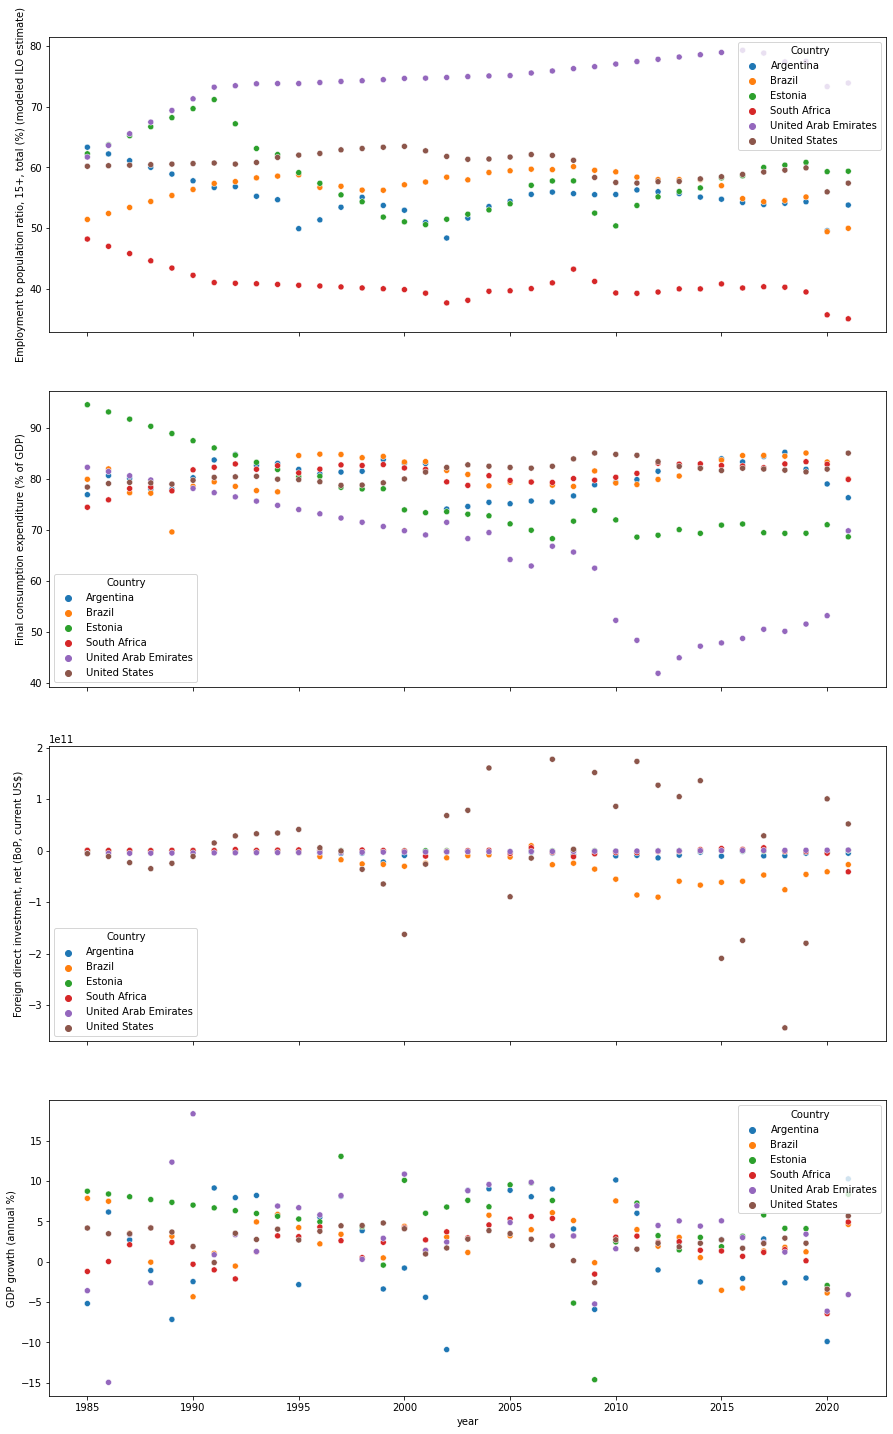

In [13]:
# Dados do World Bank

DF_play = WBC

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,25))

lista_p= ['Brazil', 'Argentina', 'Estonia', 'United States', 'United Arab Emirates', 'South Africa']

lock = DF_play.Country.isin(lista_p)
data = DF_play[DF_play['year'] >= 1985].loc[lock]

sns.scatterplot(ax=axes[0], data = data, x = data['year'] , y = data[data.columns[2]], hue= data.Country)
sns.scatterplot(ax=axes[1], data = data, x = data['year'] , y = data[data.columns[3]], hue= data.Country)
sns.scatterplot(ax=axes[2], data = data, x = data['year'] , y = data[data.columns[4]], hue= data.Country)
sns.scatterplot(ax=axes[3], data = data, x = data['year'] , y = data[data.columns[6]], hue= data.Country)


<AxesSubplot:xlabel='Year', ylabel='2C  Protection of property rights'>

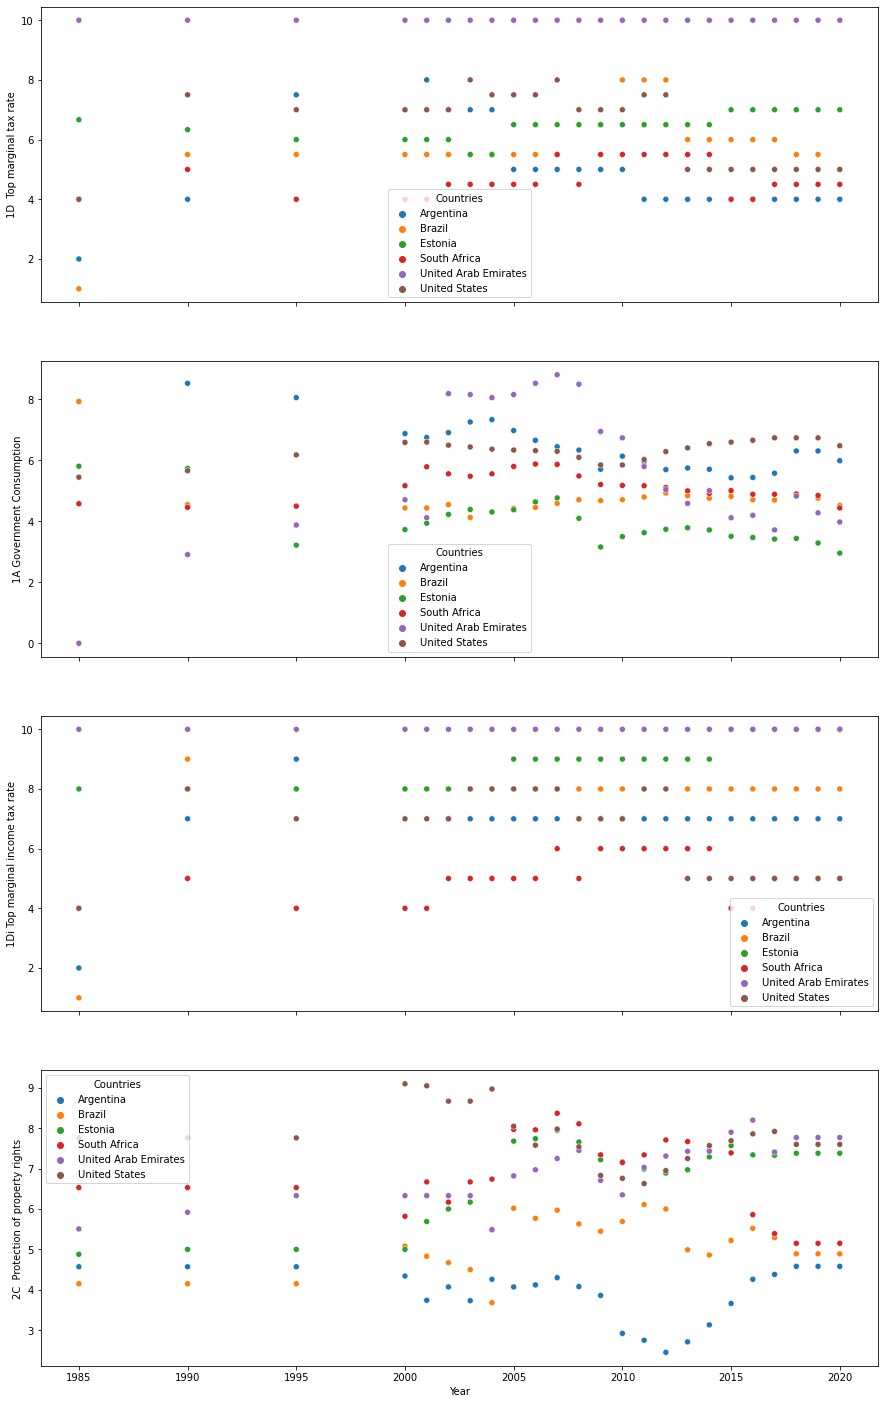

In [14]:
# Dados do World Bank

DF_play = df_efw_fra

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,25))

lista_p= ['Brazil', 'Argentina', 'Estonia', 'United States', 'United Arab Emirates', 'South Africa']

lock = DF_play.Countries.isin(lista_p)
data = DF_play[DF_play['Year'] >= 1985].loc[lock]

sns.scatterplot(ax=axes[0], data = data, x = data['Year'] , y = data[data.columns[10]], hue= data.Countries)
sns.scatterplot(ax=axes[1], data = data, x = data['Year'] , y = data[data.columns[5]], hue= data.Countries)
sns.scatterplot(ax=axes[2], data = data, x = data['Year'] , y = data[data.columns[8]], hue= data.Countries)
sns.scatterplot(ax=axes[3], data = data, x = data['Year'] , y = data[data.columns[15]], hue= data.Countries)


In [15]:
#pd.crosstab(DF_std2.Country, DF_std2.Emp_2000_2020)

# Aplicando Modelo de ML

In [16]:
### Determinando Dataframe do Modelo

feature_cols_EFW1 = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,7:109].columns)
feature_cols_EFW2 = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,109:268].columns)
feature_cols_WB = list(DF_std.iloc[:,5:7].columns) + list(DF_std.iloc[:,268:].columns)

feature_cols_base = list(DF_std.iloc[:,1:].columns)

feature_cols = feature_cols_base
feature_cols.remove('Startups_Ranking_2020')
feature_cols.remove('Startups_Score_2020')

X = DF_std[DF_std['Startups_Score_2020'] > 0 ][feature_cols].copy()
y = DF_std[DF_std['Startups_Score_2020'] > 0 ].Startups_Score_2020

#X = DF_std[feature_cols].copy()
#y = DF_std.Startups_Score_2020

#normalizando os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

SEED = 10
TS = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TS, random_state = SEED)

In [17]:
### função de Print de Resultados

def resultados(y_pred):
    print('MAE:', mean_absolute_error(y_test, y_pred).round(2))
    print('MSE:', mean_squared_error(y_test, y_pred).round(2))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
    print ('MAPE:', mean_absolute_percentage_error(y_test, y_pred).round(2))
    print('R2:', r2_score(y_test, y_pred).round(2))

## Linear Regression

In [18]:
"""
filterlist = list(DF_std.columns[list(DF_std.isna().sum() > 0)])

DF_NaN = DF_std.loc[:, DF_std.columns.isin(filterlist)].copy()

#DF_NaN[DF_NaN.EFW2_1Dii_80_20.isna()]

set(DF_std.Country).difference(set(DF_std.iloc[list(DF_NaN.dropna().index)].Country))
"""

'\nfilterlist = list(DF_std.columns[list(DF_std.isna().sum() > 0)])\n\nDF_NaN = DF_std.loc[:, DF_std.columns.isin(filterlist)].copy()\n\n#DF_NaN[DF_NaN.EFW2_1Dii_80_20.isna()]\n\nset(DF_std.Country).difference(set(DF_std.iloc[list(DF_NaN.dropna().index)].Country))\n'

In [19]:
model = LinearRegression(fit_intercept = True)

model.fit(X_train, y_train)

test_sklearn = np.array(X_test)
model.predict(test_sklearn)

y_pred = model.predict(X_test)

cv = ShuffleSplit(n_splits=5, test_size=TS, random_state=SEED)
CV = cross_val_score(model, X, y, cv=cv)

resultados(y_pred)
print('Cross Validation:', CV.round(2))

MAE: 9.36
MSE: 127.9
RMSE: 11.31
MAPE: 8.11
R2: -7.43
Cross Validation: [-7.43 -2.34  0.77 -6.   -0.06]


## Linear Lasso Regression

In [20]:
alpha = 1.83
max_iter = 1

model_l = Lasso(alpha=alpha, max_iter= max_iter)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TS, random_state = SEED)

model_l.fit(X_train, y_train)
ypred_lasso = model_l.predict(X_test)

#print('Coeficientes: ', model_l.coef_)

cv = ShuffleSplit(n_splits=5, test_size=TS, random_state=SEED)
CV = cross_val_score(model_l, X, y, cv=cv)

resultados(ypred_lasso)
print('Cross Validation:', CV.round(2))

MAE: 3.9
MSE: 18.54
RMSE: 4.31
MAPE: 2.96
R2: -0.22
Cross Validation: [-0.22  0.14  0.06 -0.2  -0.2 ]


In [21]:
G = DF_std[feature_cols].copy()
#X_train.columns[model_l.coef_ > 0]
G.columns, G.columns[model_l.coef_  > 0]

(Index(['No_billionaires', 'Networth_bill', 'No_unicorns',
        'Valuation_startups_US$_billions', 'EFW1_Econ_80_00', 'EFW1_Econ_00_10',
        'EFW1_Econ_10_20', 'EFW1_Free_80_00', 'EFW1_Free_00_10',
        'EFW1_Free_10_20',
        ...
        'WB_Popu_10_20', 'WB_Rura_80_00', 'WB_Rura_00_10', 'WB_Rura_10_20',
        'WB_Serv_80_00', 'WB_Serv_00_10', 'WB_Serv_10_20', 'WB_Unem_80_00',
        'WB_Unem_00_10', 'WB_Unem_10_20'],
       dtype='object', length=298),
 Index(['No_billionaires', 'Networth_bill', 'No_unicorns', 'EFW2_2L_80_00'], dtype='object'))

### Análise dos resultados

(<Figure size 1080x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Comparação de Valores'}, xlabel='Country Index', ylabel='Startups_Score_2020'>)

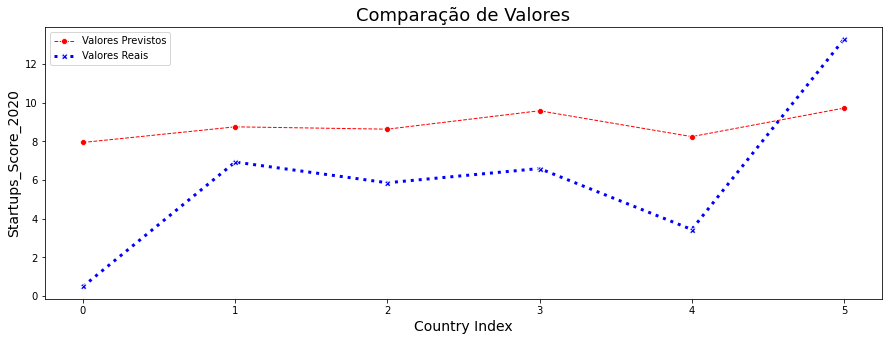

In [22]:
ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=range(len(ypred_lasso)), y=ypred_lasso,
             label="Valores Previstos",
             color='red', marker='o',
             linestyle='--', linewidth=1)

sns.lineplot(x=range(len(ypred_lasso)),y=y_test,
             label="Valores Reais",
             color='blue', marker='X',
             linestyle=':', linewidth=3)

plt.legend(loc="best")
plt.title('Comparação de Valores', fontsize=18)
plt.xlabel('Country Index', fontsize=14)
plt.ylabel('Startups_Score_2020', fontsize=14)
plt.xticks(rotation=0)
ax

<AxesSubplot:xlabel='Startups_Score_2020', ylabel='Density'>

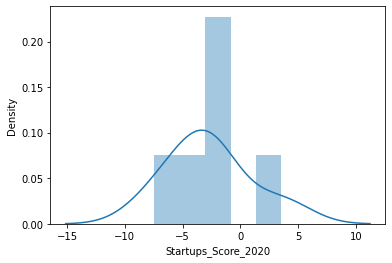

In [23]:
#ytest = ytest.astype(float)
sns.distplot(y_test - ypred_lasso)

### Gridsearch Lasso

In [24]:
m_lasso = Lasso(random_state=SEED, fit_intercept=True)

alphas = np.logspace(-1, 2, 20)
max_iter_range = np.arange(10, 20, 1)

tuned_parameters = [dict(alpha= alphas,
                         max_iter = max_iter_range)]
n_folds = 3

clf = GridSearchCV(m_lasso, param_grid = tuned_parameters, cv=n_folds, refit=False, return_train_score=True)

clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

#scores, scores_std, 
clf.best_score_, clf.best_params_

(-0.07791256373453315, {'alpha': 1.8329807108324356, 'max_iter': 17})

In [25]:
#heatmap pós limpeza dos outliers
#plt.figure(figsize=(15,10))
#sns.heatmap(DF_std2.corr(), annot = True, cmap ='Blues')

<AxesSubplot:xlabel='Country', ylabel='EFW1_Econ_10_20'>

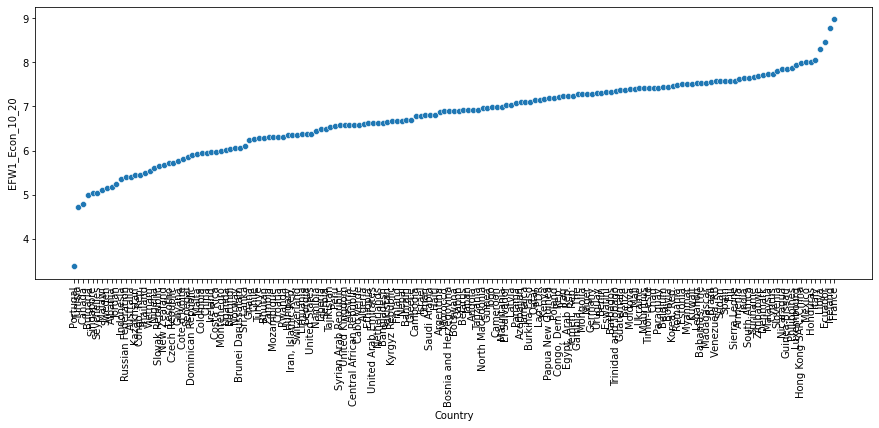

In [26]:
# Gráfico de Ranking

topic = 'EFW1_Econ_10_20'

data = DF_std.sort_values(by = topic).reset_index(drop=True)

ax = sns.scatterplot(data = data , x = data.Country , y = data[topic])
ax.figure.set_size_inches(15, 5)
plt.xticks(rotation=90)

ax

<AxesSubplot:xlabel='Country', ylabel='EFW1_Econ_10_20'>

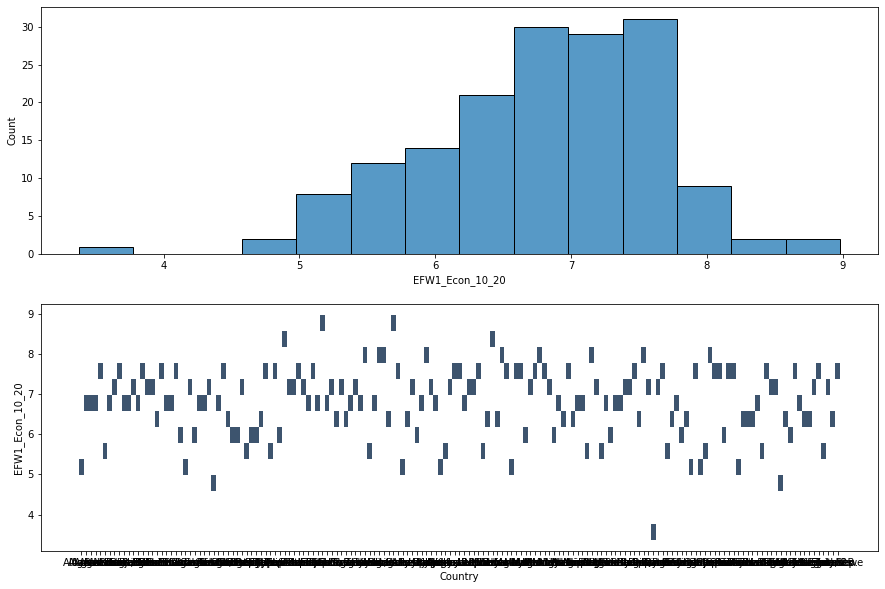

In [27]:
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(15,10))

sns.histplot(ax=axes[0], data = DF_std.EFW1_Econ_10_20)

sns.histplot(ax=axes[1], data = DF_std,  
             x = 'Country',
             y = 'EFW1_Econ_10_20')

## Elastic Net Regression

In [28]:
# Fit regression model
alpha = 1.08
model_en = ElasticNet(alpha=alpha,
                      l1_ratio=0.5,
                      fit_intercept=True,
                      max_iter=6,
                      tol=0.0001,
                      random_state=SEED)

model_en.fit(X_train, y_train)

ypred_en = model_en.predict(X_test)

resultados(ypred_en)
#print('Cross Validation:', CV.round(2))

#print('Coeficientes: ', model_en.coef_)

MAE: 6.15
MSE: 43.64
RMSE: 6.61
MAPE: 3.27
R2: -1.88


In [29]:
#G = DF_std[feature_cols].copy()
G.columns[model_en.coef_  > 0.5]
#model_en.coef_[model_en.coef_ > 0]

Index(['No_billionaires', 'Networth_bill', 'No_unicorns',
       'Valuation_startups_US$_billions', 'EFW1_Quar_80_00', 'EFW2_Econ_80_00',
       'EFW2_2A_80_00', 'EFW2_2C_80_00', 'EFW2_2C_00_10', 'EFW2_2EI_80_00',
       'EFW2_2FL_80_00', 'EFW2_2L_80_00', 'EFW2_4Di_80_00', 'EFW2_5B_00_10',
       'EFW2_5B_10_20', 'EFW2_5Ci_80_00', 'EFW2_5Civ_80_00', 'EFW2_5R_80_00',
       'WB_Serv_80_00', 'WB_Serv_00_10', 'WB_Serv_10_20'],
      dtype='object')

### Gridsearch Elastic Net

In [30]:
model_en = ElasticNet(l1_ratio=0.5, fit_intercept=True, tol=0.0001, random_state=SEED)

alphas = np.logspace(-1, 1, 30)
max_iter_range = np.arange(1, 10, 1)

tuned_parameters = [dict(alpha= alphas,
                         max_iter = max_iter_range)]
n_folds = 5

clf = GridSearchCV(model_en, param_grid = tuned_parameters, cv=n_folds, refit=False, return_train_score=True)

clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

#scores, scores_std, 
clf.best_score_, clf.best_params_

(-0.1529466712466962, {'alpha': 1.0826367338740546, 'max_iter': 7})

(<Figure size 1080x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Comparação de Valores'}, xlabel='Country Index', ylabel='Startups_Score_2020'>)

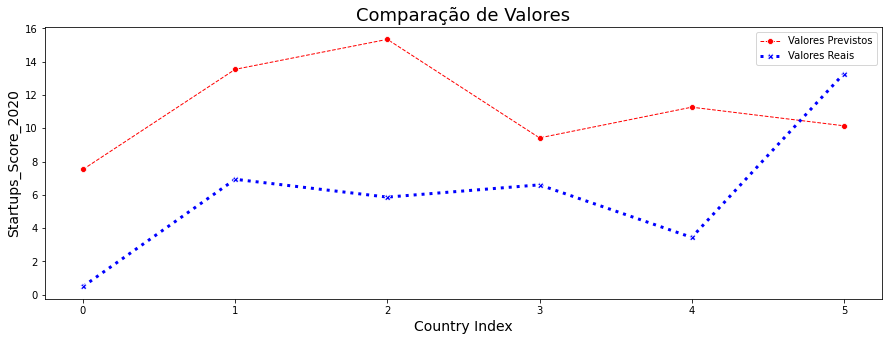

In [31]:
ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=range(len(ypred_en)), y=ypred_en,
             label="Valores Previstos",
             color='red', marker='o',
             linestyle='--', linewidth=1)

sns.lineplot(x=range(len(ypred_en)),y=y_test,
             label="Valores Reais",
             color='blue', marker='X',
             linestyle=':', linewidth=3)

plt.legend(loc="best")
plt.title('Comparação de Valores', fontsize=18)
plt.xlabel('Country Index', fontsize=14)
plt.ylabel('Startups_Score_2020', fontsize=14)
plt.xticks(rotation=0)
ax

In [32]:
#df_efw_fra.columns

## Decision Tree

In [48]:
# Fit regression model
regr = tree.DecisionTreeRegressor(criterion='squared_error',
                                  splitter='best',
                                  ccp_alpha=0.11,
                                  max_depth=3,
                                  min_samples_split=3,
                                  min_samples_leaf=3,
                                  min_weight_fraction_leaf=0.0,
                                  max_features=None,
                                  random_state=None,
                                  max_leaf_nodes=None,
                                  )
regr.fit(X_train, y_train)
ypred_dt = regr.predict(X_test)

resultados(ypred_dt)

MAE: 3.59
MSE: 16.8
RMSE: 4.1
MAPE: 1.44
R2: -0.11


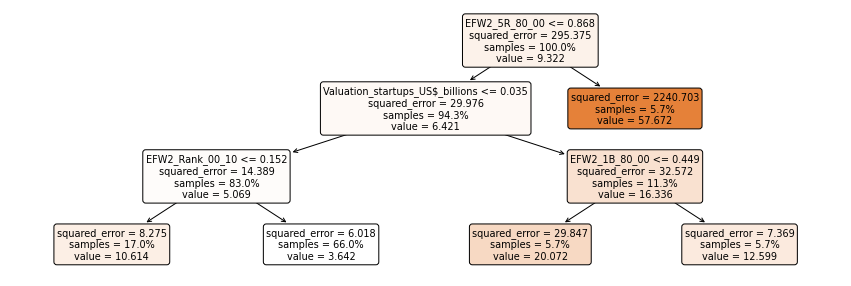

In [49]:
fig = plt.figure(figsize=(15,5))
_ = tree.plot_tree(regr,feature_names=feature_cols,filled=True,rounded=True, proportion=True)
plt.show()

In [35]:
y_train_pred = regr.predict(X_train)
ypred_dt = regr.predict(X_test)

mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, ypred_dt)  

(131.7851612921833, 18.529069171885862)

(<Figure size 1080x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Comparação de Valores'}, xlabel='Country Index', ylabel='Startups_Score_2020'>)

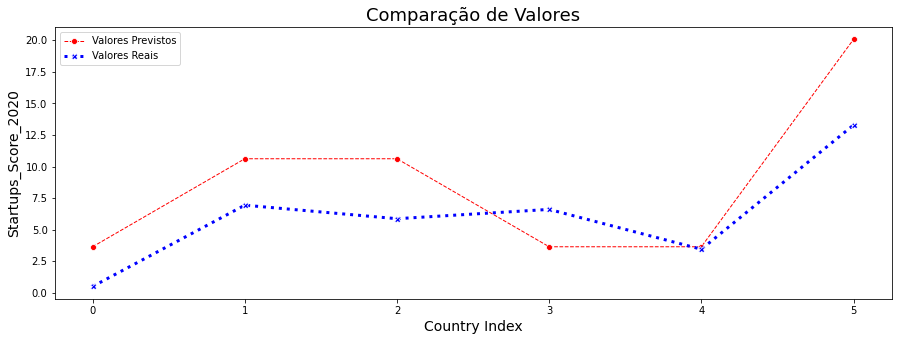

In [50]:
ax = plt.subplots(figsize=(15,5))

#ypred_dt = regr.predict(X)

sns.lineplot(x=range(len(ypred_dt)), y=ypred_dt,
             label="Valores Previstos",
             color='red', marker='o',
             linestyle='--', linewidth=1)

sns.lineplot(x=range(len(ypred_dt)),y=y_test,
             label="Valores Reais",
             color='blue', marker='X',
             linestyle=':', linewidth=3)

plt.legend(loc="best")
plt.title('Comparação de Valores', fontsize=18)
plt.xlabel('Country Index', fontsize=14)
plt.ylabel('Startups_Score_2020', fontsize=14)
plt.xticks(rotation=0)
ax

### GridsearchCV Decision Tree

In [37]:
alpha_range = np.arange(0, 1, 0.01)
max_depth_range = np.arange(1, 5, 1)
min_samples_split_range = np.arange(2, 5, 1)
min_samples_leaf_range = np.arange(2, 5, 1)


param_grid = dict(ccp_alpha = alpha_range, 
                  max_depth = max_depth_range,
                  min_samples_split = min_samples_split_range,
                  min_samples_leaf = min_samples_leaf_range)

folds = KFold(n_splits=5, random_state=17, shuffle=True)

grid = GridSearchCV(regr, param_grid, cv = folds, scoring = 'neg_mean_squared_error')

grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
             estimator=DecisionTreeRegressor(ccp_alpha=0.86, max_depth=4,
                                             min_samples_leaf=3),
             param_grid={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0....
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                         'max_depth': array([1, 2, 3, 4]),
                         'min_samples_leaf': array([2, 3, 4]),
                         'min_samples_split': array([2, 3, 4])},
             scoring='neg_mean_squared_error')

In [38]:
grid.best_params_

{'ccp_alpha': 0.11,
 'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

In [39]:
text_representation = tree.export_text(regr)
print(text_representation)

|--- feature_262 <= 0.87
|   |--- feature_3 <= 0.04
|   |   |--- feature_110 <= 0.15
|   |   |   |--- feature_261 <= 0.81
|   |   |   |   |--- value: [8.57]
|   |   |   |--- feature_261 >  0.81
|   |   |   |   |--- value: [13.17]
|   |   |--- feature_110 >  0.15
|   |   |   |--- feature_128 <= 0.40
|   |   |   |   |--- value: [5.57]
|   |   |   |--- feature_128 >  0.40
|   |   |   |   |--- value: [2.35]
|   |--- feature_3 >  0.04
|   |   |--- feature_215 <= 0.68
|   |   |   |--- value: [12.60]
|   |   |--- feature_215 >  0.68
|   |   |   |--- value: [20.07]
|--- feature_262 >  0.87
|   |--- value: [57.67]



## KMeans

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

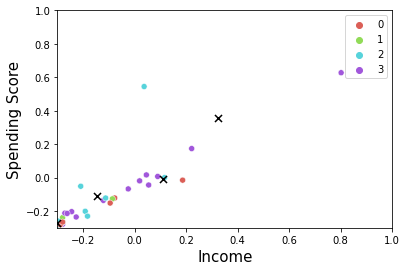

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters = 4,
                n_init = 10,
                random_state = 0
               ) # Número de repetições = 10

kmeans.fit(X_scaled)

labels = kmeans.labels_ # Rótulos que indicam a qual cluster os dados pertencem
centroids = kmeans.cluster_centers_ # Coordenadas dos centróides

sns.scatterplot(x = X_scaled[ : , 0],
                y = X_scaled[ : , 1],
                hue = labels, 
                legend = 'full',
                palette = sns.color_palette("hls", 4)
               );


plt.xlabel('Income', fontsize = 15); 
plt.ylabel('Spending Score', fontsize = 15);

plt.scatter(centroids[ : , 0], 
            centroids[ : , 1], 
            marker = 'x', 
            s = 50, 
            color = 'k'
           );

plt.ylim((-0.3,1))
plt.xlim((-0.3,1))
plt.figure

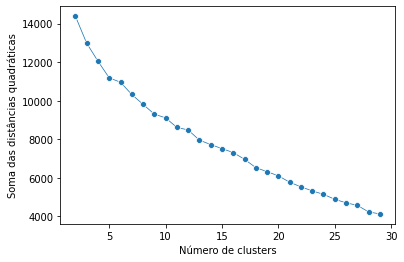

In [41]:
sq_distances = []
k_values = range(2,30);

for k in k_values:
    kmeans = KMeans(n_clusters = k, 
                    n_init = 10, 
                    random_state = 0
                   )
    kmeans.fit(X_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x = k_values, 
             y = sq_distances, 
             marker = 'o', 
             size = 30, 
             legend = False
            );
plt.ylabel('Soma das distâncias quadráticas');
plt.xlabel('Número de clusters');    

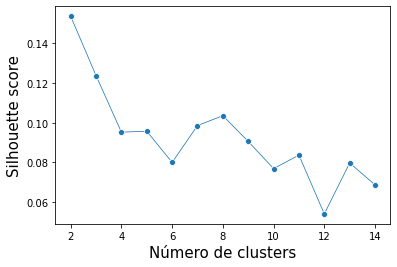

In [42]:
from sklearn.metrics import silhouette_score, silhouette_samples

sil = []
k_values = range(2,15);

for k in k_values:
    kmeans = KMeans(n_clusters = k, 
                    n_init = 10, 
                    random_state = 0
                   ) 
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, 
                             kmeans.labels_
                            )
    sil.append(score)

sns.lineplot(x = k_values,
             y = sil, 
             marker = 'o', 
             size = 30,
             legend = False
            );
plt.ylabel('Silhouette score', fontsize = 15);
plt.xlabel('Número de clusters',fontsize = 15);

## XGBoost

- learning_rate >>> step size shrinkage used to prevent overfitting. Range is [0,1]

- max_depth >>> determines how deeply each tree is allowed to grow during any boosting round.

- subsample >>> percentage of samples used per tree. Low value can lead to underfitting.

- colsample_bytree >>> percentage of features used per tree. High value can lead to overfitting.

- n_estimators >>> number of trees you want to build.

- objective >>> determines the loss function to be used like reg:linear for regression problems, reg logistic for classification problems with only decision, binary:logistic for classification problems with probability.

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.

- alpha: L1 regularization on leaf weights. A large value leads to more regularization.

- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [43]:
data = X
label = y

data_dmatrix = xgb.DMatrix(data=data,label=label)

model_xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                                alpha = 0.01,
                                colsample_bytree = 0.3, 
                                learning_rate = 0.14,
                                max_depth = 2, 
                                n_estimators = 10)

model_xg_reg.fit(X_train,y_train)
ypred_xgb = model_xg_reg.predict(X_test)

resultados(ypred_xgb)
#xgb.plot_importance(model_xg_reg)
#xgb.to_graphviz(model_xg_reg, num_trees=2)

[11:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 1.0
MSE: 1.67
RMSE: 1.29
MAPE: 0.93
R2: 0.89


### Gridsearch XGBoost

In [44]:
params = {"objective": ["reg:linear"],
          'alpha': np.logspace(-2, 2, 20),
          'colsample_bytree': [0.3],
          'learning_rate':  np.arange(0, 0.2, 0.02),
          'max_depth': [2],  #np.arange(2, 10, 1),
          'n_estimators': [10]} #np.arange(6, 12, 2)}


xgb_grid = GridSearchCV(estimator=model_xg_reg,
                        param_grid=params,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[11:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.018078808990550255
{'alpha': 0.01, 'colsample_bytree': 0.3, 'learning_rate': 0.14, 'max_depth': 2, 'n_estimators': 10, 'objective': 'reg:linear'}


In [45]:
XG = DF_std[feature_cols].copy()
list(XG.columns[model_xg_reg.feature_importances_ > 0])

['No_billionaires',
 'Networth_bill',
 'No_unicorns',
 'Valuation_startups_US$_billions',
 'EFW2_Econ_80_00',
 'EFW2_2C_80_00',
 'EFW2_4Bii_00_10',
 'EFW2_4F_00_10',
 'EFW2_5B_00_10']

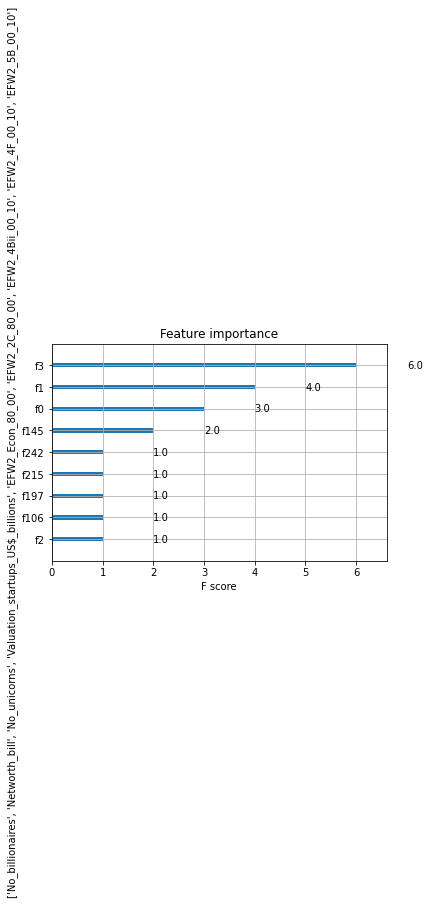

In [46]:
XG = DF_std[feature_cols].copy()
labels = list(XG.columns[model_xg_reg.feature_importances_ > 0])

xgb.plot_importance(model_xg_reg,
                    ylabel=labels)
#plt.ylabel(ylabel=labels, rotation=0)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

# Rascunhos

In [47]:
DF_std[(DF_std['Startups_Ranking_2020'] <= 10) & 
       (DF_std['Startups_Ranking_2020'] > 0)].sort_values(by='Startups_Ranking_2020')

,Country,No_billionaires,Networth_bill,No_unicorns,Valuation_startups_US$_billions,Startups_Ranking_2020,Startups_Score_2020,EFW1_Econ_80_00,EFW1_Econ_00_10,EFW1_Econ_10_20,...,WB_Popu_10_20,WB_Rura_80_00,WB_Rura_00_10,WB_Rura_10_20,WB_Serv_80_00,WB_Serv_00_10,WB_Serv_10_20,WB_Unem_80_00,WB_Unem_00_10,WB_Unem_10_20
154,United States,719.0,4685.10,215.0,1111.21,1.0,124.420,4.871538,6.105455,6.37875,...,3.204397e+08,24.109143,20.077091,18.310273,71.855840,74.502519,76.843204,5.639667,5.909091,6.392727
153,United Kingdom,49.0,199.10,30.0,183.55,2.0,28.719,6.000000,6.000000,6.57500,...,6.505639e+07,21.621524,20.081818,17.383273,65.638920,68.960103,70.713743,6.932095,5.546364,5.817455
72,Israel,29.0,111.60,33.0,61.35,3.0,27.741,6.540000,6.680909,6.78625,...,8.396945e+06,9.742667,8.483727,7.810000,58.703464,66.221061,69.014469,10.489833,10.861818,5.543636
28,Canada,64.0,307.90,19.0,48.83,4.0,19.876,4.780000,4.780000,4.78750,...,3.587636e+07,22.957762,19.800727,18.733636,58.108799,63.215988,65.911303,8.200833,7.102727,7.094545
55,Germany,130.0,604.00,18.0,47.35,5.0,17.053,4.992308,7.037273,7.28750,...,8.181434e+07,26.535714,24.026000,22.773455,58.795812,62.725086,62.140579,8.064024,8.817273,4.654545
139,Sweden,45.0,165.70,8.0,65.39,6.0,15.423,5.079231,5.298182,5.15000,...,9.839156e+06,16.594619,15.570455,13.470636,57.788155,62.003800,64.903107,7.232262,6.483636,7.546364
32,China,515.0,1938.45,86.0,764.26,7.0,15.128,3.417692,5.562727,5.95125,...,1.377955e+09,73.002714,57.495545,44.558364,31.379574,42.175996,49.718237,4.412810,4.319091,4.568182
140,Switzerland,41.0,181.90,4.0,5.00,8.0,14.943,4.687692,5.999091,6.35375,...,8.258719e+06,26.061571,26.518727,26.269091,66.125392,69.526979,71.434854,4.298833,3.716364,4.700000
5,Australia,44.0,205.10,6.0,51.20,9.0,13.835,5.400000,5.400000,5.40000,...,2.385087e+07,14.785667,15.395000,14.293636,59.504727,64.339080,66.262167,12.128262,5.445455,5.592727
131,Singapore,25.0,105.70,8.0,8.20,10.0,13.745,5.996923,6.227273,5.03000,...,5.474939e+06,0.000000,0.000000,0.000000,61.977391,64.985831,69.996238,3.524833,4.799091,3.840273
